##### Tiago Lyrio

RA: 046799

In [1]:
import imageio.v2 as iio
import cv2
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MultipleLocator
sns.set()

# Importando as Imagens

##### Importando o banco de imagens

In [2]:
from os import listdir, path

def read_imgs(loc='local',img_path=''):
    '''
    Lê imagens e retorna as imagens em um numpy array e os nomes da imagem em uma lista.
    Return: images, img_name
    
    Entradas:
    loc - local onde estão as imagens:
        'local' - procura as imagens em um diretório local
        'url'   - procura as imagens em uma tabela em um url
    '''
    #lê as imagens de um caminho local
    if loc=='local':
        
        img_names = [f for f in listdir(img_path) if path.isfile(img_path+f)]
        
        images = []
        for img in img_names:
            images.append(iio.imread(img_path+img))
        
    #lê as imagens do url (específicamente das imagnes na tabela do prof Hélio)
    elif loc=='url':
        #lê a tabela de imagens no site, retira valores nulos e o cabeçalho da coluna
        img_names = pd.read_html(img_path)[0]['Name'].dropna().drop(1)
        #ignora as imagens com 'perspectiva' no nome. Não faz sentido usar aqui
        img_names = img_names[~img_names.str.contains('perspectiva')]
        
        #lê as imagens do URL e salva nessa lista
        images = [iio.imread(img_path+img) for img in img_names if 'perspectiva' not in img]
    
    else:
        raise ValueError(f'read_imgs: loc = \'{loc}\'  não é um local válido.')
        
    #transforma num numpy array
    images = np.array(images)
    
    #imprime detalhes das imagens lidas
    print('total de imagens:',len(img_names))
    print('imagens:',img_names.tolist())
    print('\nDetalhes:')
    for img,img_name in zip(images,img_names):
        print(f'{img_name}: \tmax = {img.max()} \tmin = {img.min()} \tshape = {img.shape} \ttype = {img.dtype}')
        
    return images,img_names.tolist()

In [3]:
img_path = 'https://www.ic.unicamp.br/~helio/imagens_png/'
#img_path = 'imagens/'

images,img_names = read_imgs(loc='url',img_path=img_path)

total de imagens: 5
imagens: ['baboon.png', 'butterfly.png', 'city.png', 'house.png', 'seagull.png']

Detalhes:
baboon.png: 	max = 230 	min = 0 	shape = (512, 512) 	type = uint8
butterfly.png: 	max = 212 	min = 27 	shape = (512, 512) 	type = uint8
city.png: 	max = 235 	min = 16 	shape = (512, 512) 	type = uint8
house.png: 	max = 255 	min = 0 	shape = (512, 512) 	type = uint8
seagull.png: 	max = 255 	min = 24 	shape = (512, 512) 	type = uint8


In [4]:
#Adicionando mais uma imagem
camera_img = iio.imread('imageio:camera.png')
img_names.append('camera.png')
images = np.append(images,[camera_img],0)

Todas as imagens tem o mesmo tamanho, o mesmo tipo (uint8) e tem seus valores entre 0 e 255.

##### Visualizando as imagens

In [5]:
def plot_images(images,
                img_names,
                images_per_line = 3, 
                img_size = 3):
    '''
    Recebe uma lista de imagens com 256 tons de cinza e plota elas.
    images -> lista ou np.array de imagens
    img_names -> nomes a serem usados no plot
    images_per_line -> numero de imagens por linha
    img_size -> tamanho individual de cada imagem.
    
    não retorna nada, só plota
    '''
    
    #imagens por coluna
    images_per_row = int(np.ceil((len(images)/images_per_line)))

    #cria a figura
    fig, axes = plt.subplots(images_per_row,
                             images_per_line,
                             figsize=(img_size*images_per_line,img_size*images_per_row))
    
    if len(images)>1:
        axes = axes.ravel()
    else:
        axes=[axes]

    #número de espaços em branco na ficura
    blank_axes = images_per_line*images_per_row - len(img_names)

    #plota as imagens com seus respectivos nomes
    #é utilizado vmin=0 e vmax=255 para impedir que a biblioteca normalize os valores na hora de plotar a imagem
    for ax,img,img_name in zip(axes,images,img_names):
        ax.imshow(img, cmap='gray',vmin=0,vmax=255)
        ax.grid(False)
        ax.set_title(img_name)
        #ax.set_axis_off()
        ax.tick_params(    
            axis='both',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False)         # ticks along the top edge are off)

    #deixa em branco os espaços não utilizados na figura
    for ax in axes[-blank_axes:]:
        ax.set_axis_off()
        
    return axes

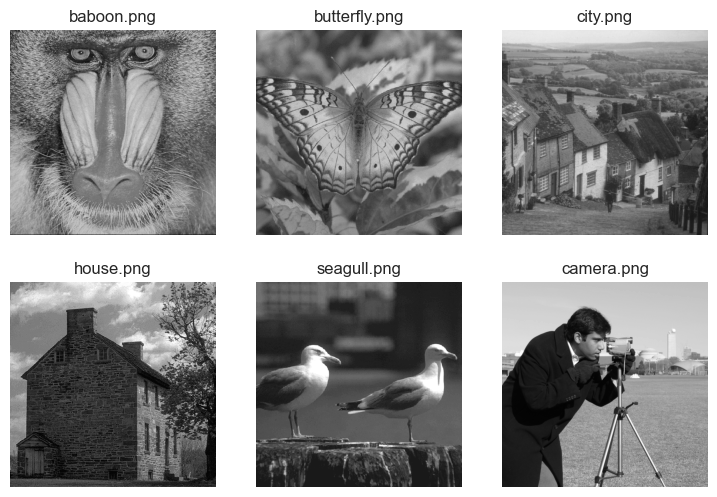

In [6]:
plot_images(images,img_names,images_per_line = 3, img_size = 3);

##### Histograma das imagens

In [7]:
#cria a figura
#fig, axes = plt.subplots(len(img_files),2, figsize=(10,3*len(img_files)))
#axes = axes.ravel()

def plot_histogram(img,label,ax=None,show_stats=False,ylim=None):
    '''Plota uma única imagem com 256 tons de cinza e seu respectivo histograma
        img        -> imagem a ser plotada
        label      -> rotulo para mostrar no gráfico
        ax         -> eixos com duas posições. Uma para a imagem, outra para o histograma
        show_stats -> (boolean) plota a média e a mediana no histograma
        
    não retorna nada, só plota
    '''
    #plota a imagem
    #é utilizado vmin=0 e vmax=255 para impedir que a biblioteca normalize os valores na hora de plotar a imagem
    ax[0].imshow(img, cmap='gray',vmin=0,vmax=255)
    ax[0].set_title(label)
    ax[0].grid(False)
    ax[0].set_axis_off()

    histogram, bin_edges = np.histogram(img, bins=256, range=(img.min(), img.max()))
    ax[1].plot(bin_edges[0:-1], histogram)
    ax[1].set_title(f'histogram ({label})')
    ax[1].set(xlim=(0,255))
    if ylim: ax[1].set(ylim=(0,ylim))
    
    if show_stats:
        ax[1].axvline(x = np.mean(img), color = 'r', linestyle = ':', label = "Média", linewidth=1.5)   
        ax[1].axvline(x = np.median(img), color = 'g', linestyle = ':', label = "Mediana", linewidth=1.5) 
        ax[1].legend()
    
def show_hist(images,img_names,show_stats=False,ylim=None):
    '''Plota uma lista de imagens com 256 tons de cinza e seus respectivos histogramas
        img        -> imagem a ser plotada
        label      -> rotulo para mostrar no gráfico
        ax         -> eixos com duas posições. Uma para a imagem, outra para o histograma
        show_stats -> (boolean) plota a média e a mediana no histograma
        ylim       -> coloca um limite em comum para todos os histogramas, facilitando a comparação
        
    Retorna os eixos com as imagens
    '''
    fig, axes = plt.subplots(len(img_names),2, figsize=(10,3*len(img_names)))
    for img,ax,names in zip(images,axes,img_names):
        plot_histogram(img,names,ax=ax,show_stats=show_stats,ylim=ylim)
    fig.tight_layout()
    return axes


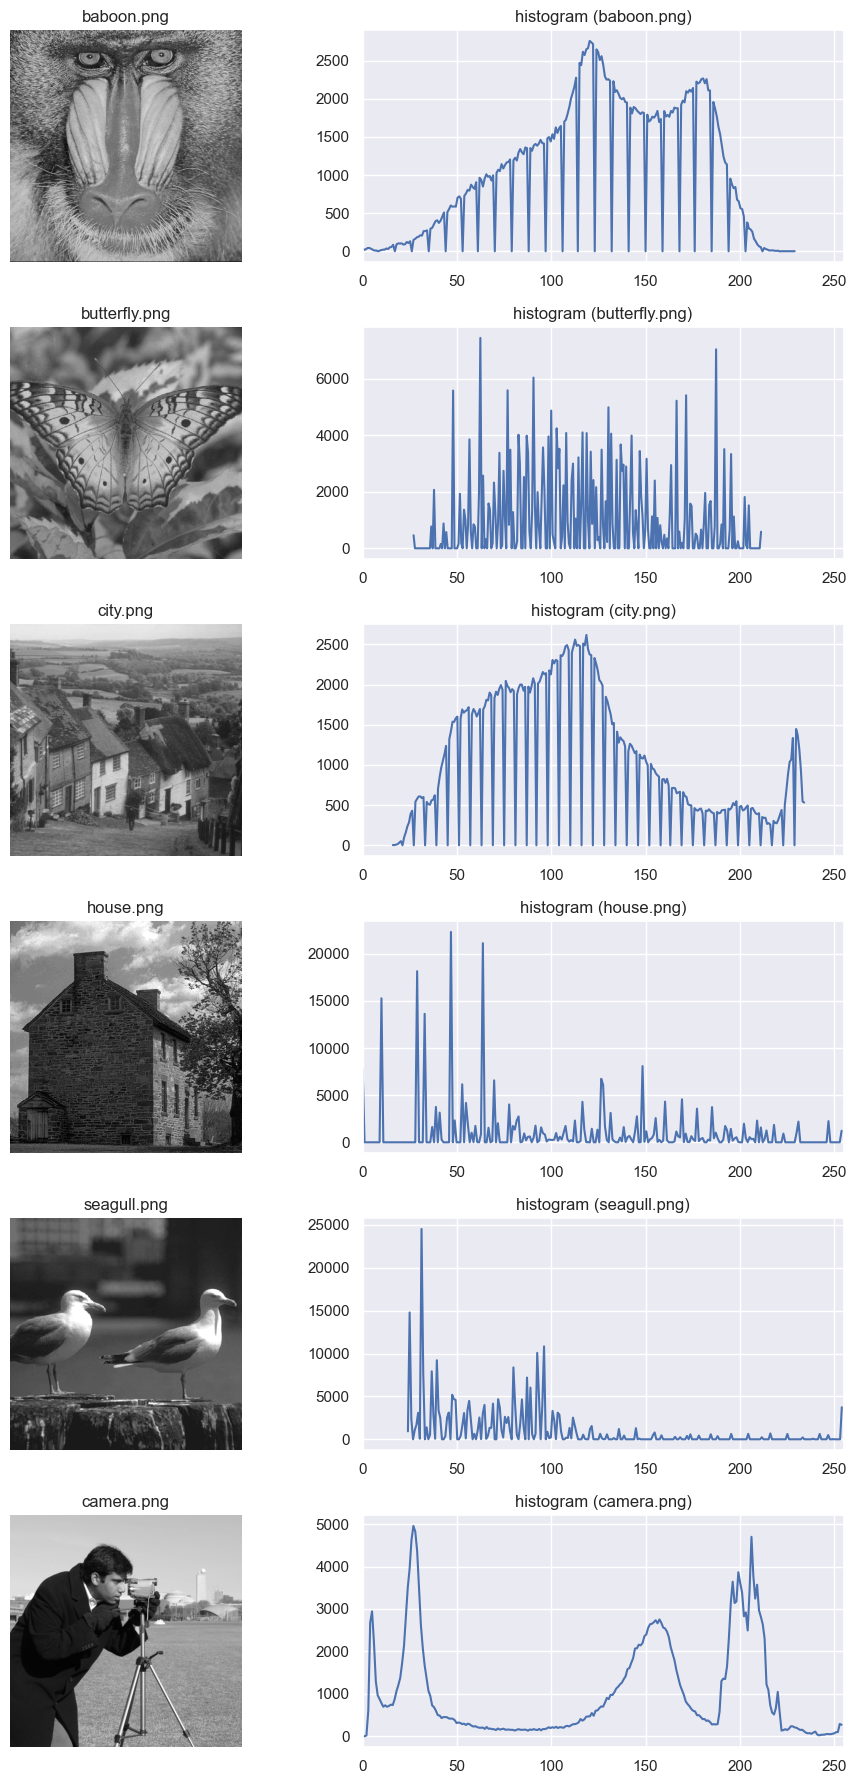

In [8]:
show_hist(images,img_names);

## Filtros de Imagens

A filtragem aplicada a uma imagem digital é uma operação local que altera os valores de intensidade
dos pixels da imagem levando-se em conta tanto o valor do pixel em questão quanto
valores de pixels vizinhos.
No processo de filtragem, utiliza-se uma operação de convolução de uma máscara pela imagem.
Este processo equivale a percorrer toda a imagem alterando seus valores conforme os pesos
da máscara e as intensidades da imagem.
Aplique os filtros h1 e h11 em uma imagem digital monocromática.

In [42]:
effect_label =[
    'Laplacian Edge (5x5)',
    'Gaussian Blur',
    'Vertical Edge (Sobel)',
    'Horizontal Edge (Sobel)',
    'Laplacian Edge (3x3)',
    'Box Filter',
    'Diagonal 45°',
    'Diagonal 135°',
    'Diagonal Blur (Movement)',
    'Sharpen',
    'Emboss'
]

In [43]:
#Laplaciano, passa alta
h1 = np.array([[ 0,  0, -1,  0,  0],
               [ 0, -1, -2, -1,  0],
               [-1, -2, 16, -2, -1],
               [ 0, -1, -2, -1,  0],
               [ 0,  0, -1,  0,  0]])

#Gaussian Filter
h2 = 1/256*np.array([[1,  4,  6,  4, 1],
                     [4, 16, 24, 16, 4],
                     [6, 24, 36, 24, 6],
                     [4, 16, 24, 16, 4],
                     [1,  4,  6,  4, 1]])

#Vertical edge (Sobel Operator)
h3 = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

#Horizontal edge (Sobel Operator)
h4 = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]])

#Edge laplacian (including diagonals), passa alta
h5 = np.array([[-1, -1, -1],
               [-1,  8, -1],
               [-1, -1, -1]])

#Box filter, passa baixa
h6 = 1/9*np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])
#45° lines
h7 = np.array([[-1, -1,  2],
               [-1,  2, -1],
               [ 2, -1, -1]])
#135° lines
h8= np.array([[ 2, -1, -1],
              [-1,  2, -1],
              [-1, -1,  2]])

#Diagonal blur
h9 = 1/9*np.eye(9)

#Sharpen Filter
h10 = 1/8*np.array([[-1, -1, -1, -1, -1],
                    [-1,  2,  2,  2, -1],
                    [-1,  2,  8,  2, -1],
                    [-1,  2,  2,  2, -1],
                    [-1, -1, -1, -1, -1]])

#Emboss
h11 = np.array([[-1, -1, 0],
                [-1,  0, 1],
                [ 0,  1, 1]])

h=[h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11]

In [44]:
def combine_filters(img, kernel_a,kernel_b, mode='max'):
    conv_a = cv2.filter2D(src=img, ddepth=-1, kernel=kernel_a)
    conv_b = cv2.filter2D(src=img, ddepth=-1, kernel=kernel_b)

    if mode=='max':
        return np.maximum(conv_a,conv_b)

    elif  mode=='root_of_sq':
        #dividimos por 255 para a intensidade dos pixels ficar entre 0 e 1
        conv_a = conv_a/255
        conv_b = conv_b/255

        #somamos os quadrados e dividimos por 2, para manter a  intensidade dos pixels entre 0 e 1
        root_of_sq = np.sqrt((np.square(conv_a) + np.square(conv_b))/2)
        
        #retornamos a escala para 0 a 255
        root_of_sq = root_of_sq*255

        return root_of_sq.astype('uint8')

### Filtros de desfoque

Também conhecido como blur ou suavização de bordas ou passa baixa

#### Gaussian Blur (h2)

O filtro gaussiano pondera a intensidade de cada elemento de acordo com uma distribuição normal. O elemento central tem o maior peso e, quanto mais distante do centro, menor o peso.

In [45]:
print(h2*256)

[[ 1.  4.  6.  4.  1.]
 [ 4. 16. 24. 16.  4.]
 [ 6. 24. 36. 24.  6.]
 [ 4. 16. 24. 16.  4.]
 [ 1.  4.  6.  4.  1.]]


In [46]:
#gerador de um binomio de newton
def newton_bin_gen(n):
    '''retorna os coeficientes do polinômio de Newton de ordem n'''
    a = np.array([1, 1])
    b = np.array([1])
    for _ in range(n-1):
        b = np.convolve(a, b)
    return b.reshape(1,b.size)

In [47]:
for n in range(8):
    print(f'n={n}: ',newton_bin_gen(n))

n=0:  [[1]]
n=1:  [[1]]
n=2:  [[1 1]]
n=3:  [[1 2 1]]
n=4:  [[1 3 3 1]]
n=5:  [[1 4 6 4 1]]
n=6:  [[ 1  5 10 10  5  1]]
n=7:  [[ 1  6 15 20 15  6  1]]


Usando n=5 e multiplicando essa matriz pela sua transposta, temos um kernel gaussiano 5x5

In [48]:
#gera o binômio
binomio_5= newton_bin_gen(5)

#multiplica a transposta do binomio por ele mesmo
gaussian_kernel = np.multiply(binomio_5.T,binomio_5)
gaussian_kernel

array([[ 1,  4,  6,  4,  1],
       [ 4, 16, 24, 16,  4],
       [ 6, 24, 36, 24,  6],
       [ 4, 16, 24, 16,  4],
       [ 1,  4,  6,  4,  1]])

Para um filtro gaussiano 7x7 teríamos:

In [50]:
#gera o binômio
binomio_7= newton_bin_gen(7)

#multiplica a transposta do binomio por ele mesmo
gaussian_kernel = np.multiply(binomio_7.T,binomio_7)
gaussian_kernel

array([[  1,   6,  15,  20,  15,   6,   1],
       [  6,  36,  90, 120,  90,  36,   6],
       [ 15,  90, 225, 300, 225,  90,  15],
       [ 20, 120, 300, 400, 300, 120,  20],
       [ 15,  90, 225, 300, 225,  90,  15],
       [  6,  36,  90, 120,  90,  36,   6],
       [  1,   6,  15,  20,  15,   6,   1]])

*para manter a magnitude da imagem, teríamos que dividir essa matriz pela soma dos seus elementos.

In [51]:
def gaussian_kernel(n):
    '''retorna um kernel Gaussiano com dimensões (n,n)'''
    if n%2 == 0:
        raise ValueError(f'gaussian_kernel: n deve ser um número ímpar')
    else:
        binomio = newton_bin_gen(n)
        kernel = np.multiply(binomio.T,binomio)
        kernel = kernel/kernel.sum()
        return kernel

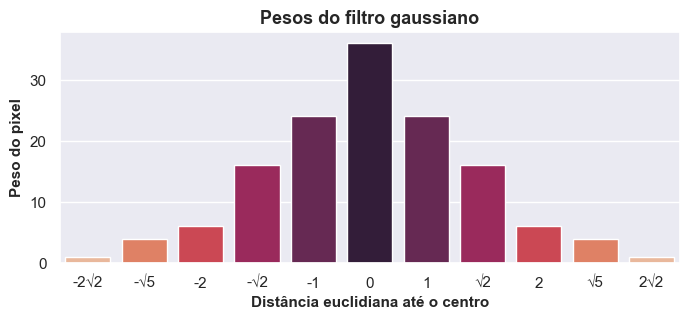

In [52]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

x = ['-2√2','-√5','-2','-√2','-1' ,'0','1','√2','2','√5','2√2']
gauss_dist = np.unique((h2*256))
gauss_dist = np.concatenate([gauss_dist,np.flip(gauss_dist[:-1])])

pallete = sns.color_palette("rocket_r") + sns.color_palette("rocket")[1:]
dist_range = int((len(gauss_dist)-1)/2)

sns.barplot(x=x,y=gauss_dist,ax=ax,palette=pallete)
ax.set_title('Pesos do filtro gaussiano', fontsize=13, fontweight='bold')
ax.set_xlabel('Distância euclidiana até o centro', fontsize=11, fontweight='bold')
ax.set_ylabel('Peso do pixel', fontsize=11, fontweight='bold');

- Foram colocadas distâncias negativas no gráficos apenas para ilustar a ideia da distribuição gaussiana

#### Box Filter (h6)

In [53]:
print(h6*9)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


O filtro 'box' gera o efeito de desfoque calculando a média dos pixels cobertos pelo filtro. Ao contrário do filtro gaussiano, todos os elementos tem o mesmo peso o que deixa ele mais rapido (reduz o custo computacional).

##### Comparando o filtro box com o filtro gaussiano

Adicionalmente, vamos utilizar um box filter 5x5 para a comparação.

In [54]:
h6_5x5 =  np.ones((5,5))
h6_5x5 /= h6_5x5.sum()
h6_5x5

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

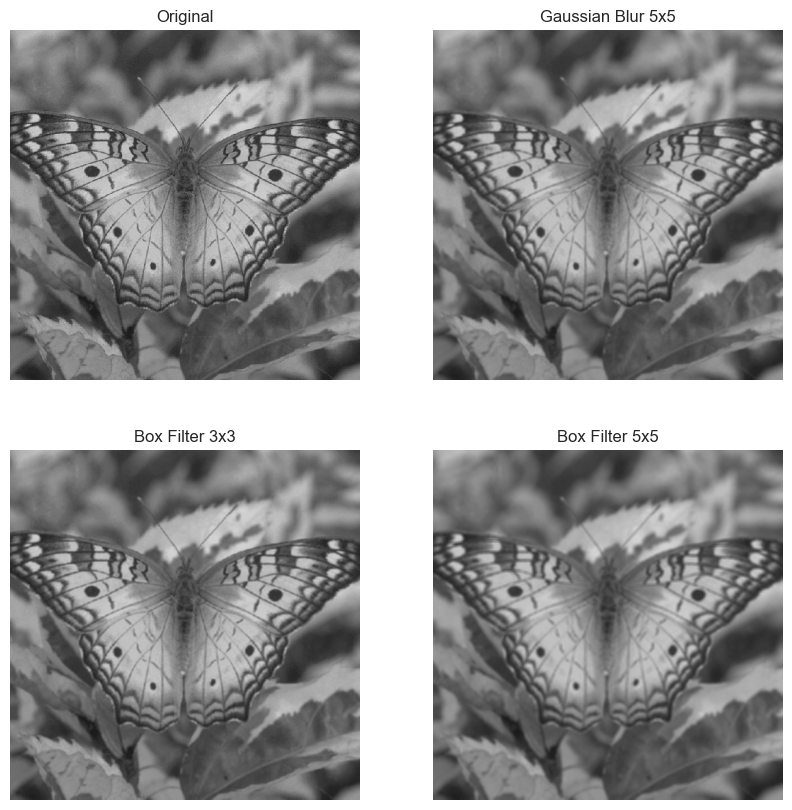

In [55]:
img = images[1]
h2_img = cv2.filter2D(src=img, ddepth=-1, kernel=h[1])
h6_img = cv2.filter2D(src=img, ddepth=-1, kernel=h[5])
h6_img_5x5 = cv2.filter2D(src=img, ddepth=-1, kernel=h6_5x5)

plot_images([img,h2_img,h6_img,h6_img_5x5], 
            ['Original',effect_label[1]+' 5x5',effect_label[5]+' 3x3',effect_label[5]+' 5x5'],
            images_per_line=2,
            img_size=5);

É possível observer que o Box filter gera um desfoque mais uniforme, enquanto o filtro gaussiano gera uma maior suavização das transições porém, mantendo um pouco mais dos contornos da imagem.

#### Diagonal Blur (h9)

In [56]:
print(h9*9)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


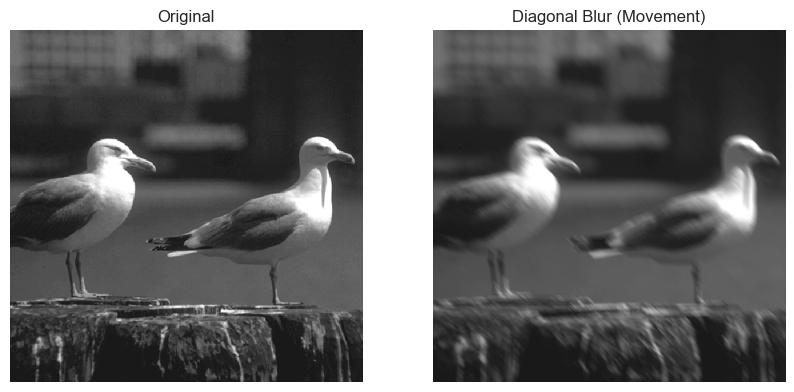

In [57]:
img = images[4]
h8_img = cv2.filter2D(src=img, ddepth=-1, kernel=h[8])
plot_images([img,h8_img], 
            ['Original',effect_label[8]],
            images_per_line=2,
            img_size=5);

Cria a sensação de movimento na diagonal (faz a média dos pixels na diagonal do kernel)

### Sharpen (h10)

Os filtros de contraste acentuam diferenças entre os pixels (o oposto do filtro de desfoque).

In [58]:
print(h10*8)

[[-1. -1. -1. -1. -1.]
 [-1.  2.  2.  2. -1.]
 [-1.  2.  8.  2. -1.]
 [-1.  2.  2.  2. -1.]
 [-1. -1. -1. -1. -1.]]


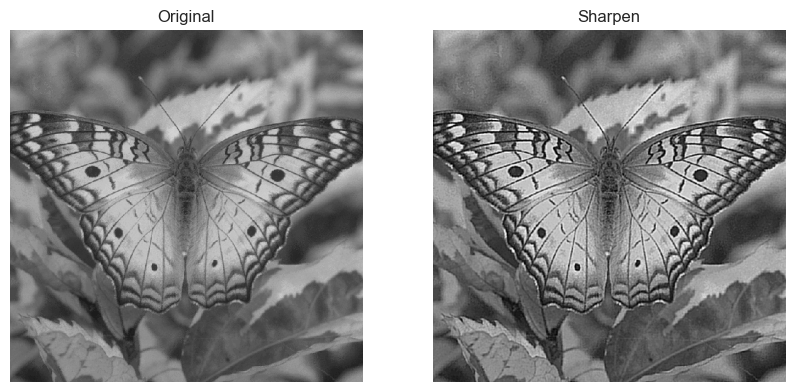

In [59]:
img = images[1]
h9_img = cv2.filter2D(src=img, ddepth=-1, kernel=h[9])
plot_images([img,h9_img], 
            ['Original',effect_label[9]],
            images_per_line=2,
            img_size=5);

É possível perceber uma maior nitidez da imagem.

### Detecção de linhas

Detecta o alinhamento de pontos em uma imagem. O kernel detecta a presença de linhas de uma largura n (em pixels) e um angulo específico. no caso de h7 e h8, temos uma inclinação de 45° e 135°, respectivamente, e n=1 para ambos.

#### Linhas Diagonais (h7 e h8)

In [60]:
h7

array([[-1, -1,  2],
       [-1,  2, -1],
       [ 2, -1, -1]])

In [61]:
h8

array([[ 2, -1, -1],
       [-1,  2, -1],
       [-1, -1,  2]])

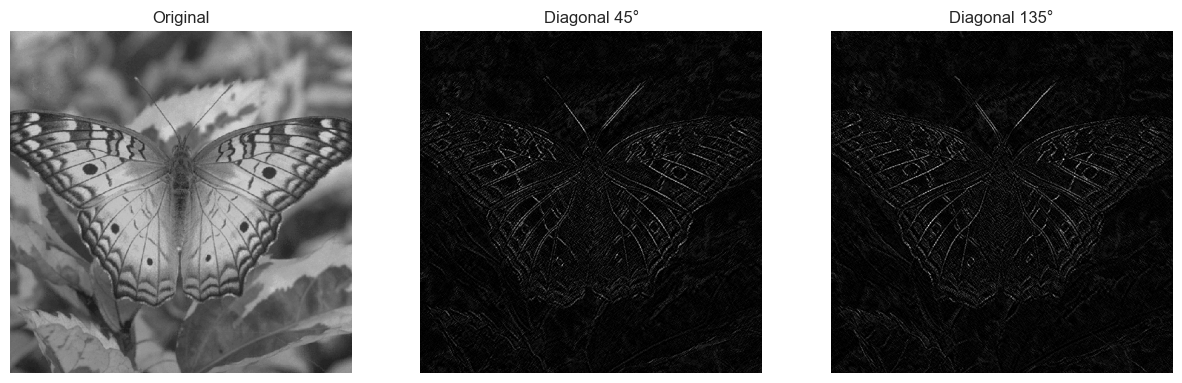

In [62]:
img = images[1]
h7_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h[6])
h8_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h[7])
plot_images([img,h7_img,h8_img], 
            ['Original',effect_label[6],effect_label[7]],
            images_per_line=3,
            img_size=5);

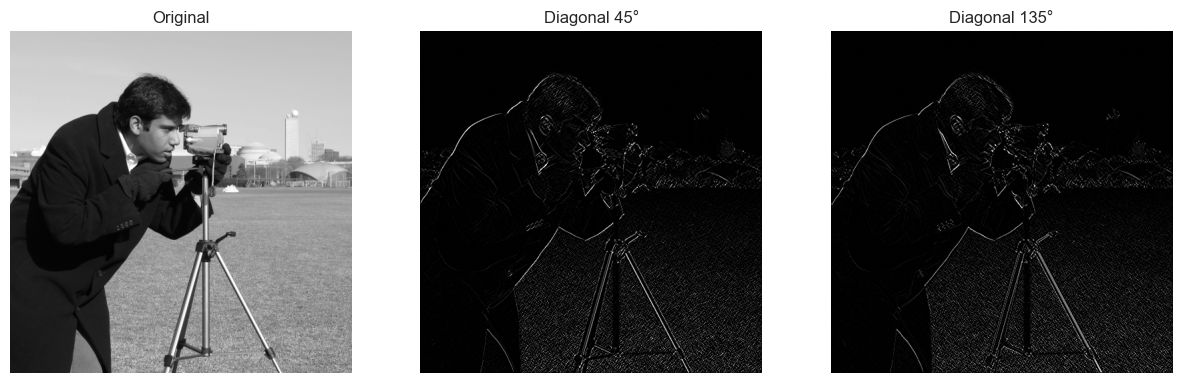

In [63]:
img = images[5]
h7_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h[6])
h8_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h[7])
plot_images([img,h7_img,h8_img], 
            ['Original',effect_label[6],effect_label[7]],
            images_per_line=3,
            img_size=5);

Era esperado que o filtro destacasse apenas os segmentos diagonais com o ângulo específico. Porém, na prática, observamos que cada filtro pega as duas diagonais, dando ênfase a um sentido específico.

### Detecção de bordas

#### Sobel (h3 e h4)

O filtro de Sobel enfatiza bordas. Ele destaca mais as bordas do que o filtro de Hewitt pois substitui os 1’s na coluna central por 2’s.

Bordas verticais

In [64]:
print(h3)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


Bordas horizontais

In [65]:
print(h4)

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


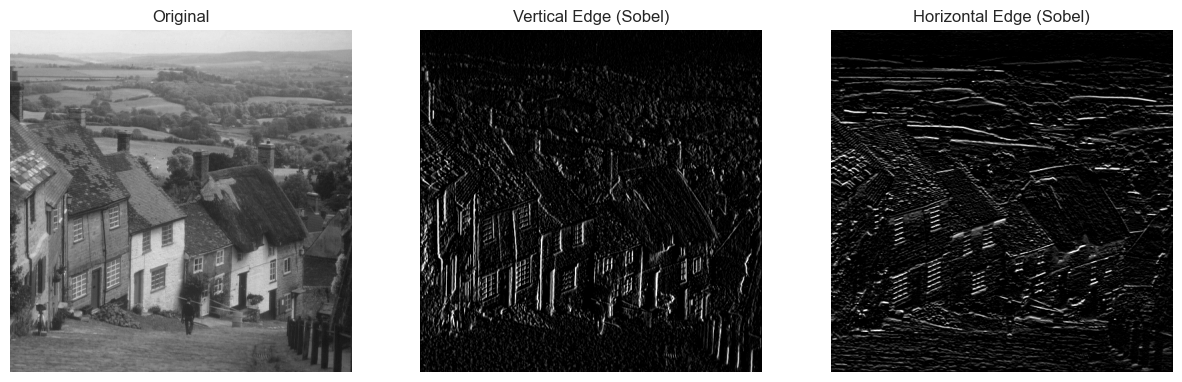

In [66]:
img = images[2]
h3_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h[2])
h4_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h[3])

plot_images([img,h3_img,h4_img], 
            ['Original',effect_label[2],effect_label[3]],
            images_per_line=3,
            img_size=5);

##### Combinando os filtros de detecção horizontal e vertical

Existem várias estratégias para combinar os filtros de detecção de borda. Vamos utilizar duas delas:
- combinar as imagens usando a seguinte expressão: $\sqrt{G1(img)^2 + G2(img)^2}$
- combinar as imagens usando os valores máximos de cada imagem gerada pelos filtros separadamente: ${max[G1(img),G2(img)]}$

*(G1 e G2 são as transformações da imagem usando os filtros de detecção de bordas horizontal e vertical, respectivamente).

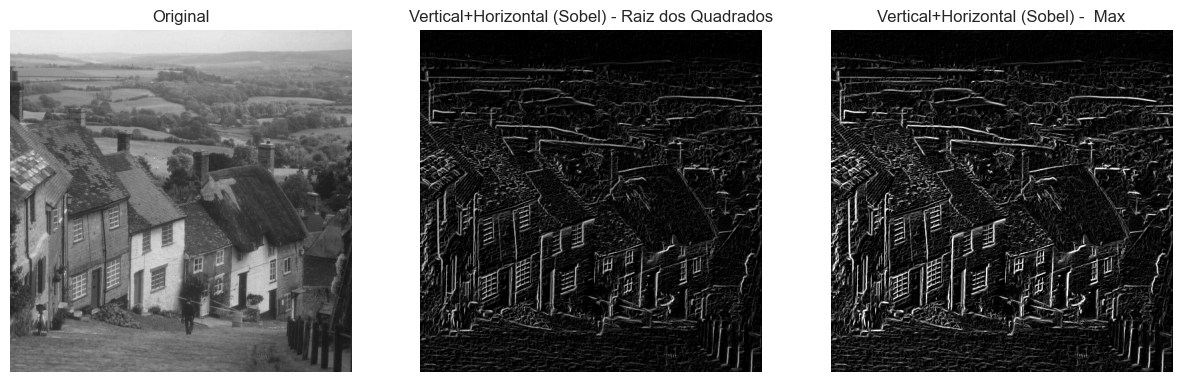

In [67]:
h34_root_of_sq = combine_filters(img, h[2],h[3],mode='root_of_sq')
h34_max = combine_filters(img, h[2],h[3],mode='max')

merge_v_h = merge_img(h3_img,h4_img)

plot_images([img,h34_root_of_sq,h34_max], 
            ['Original','Vertical+Horizontal (Sobel) - Raiz dos Quadrados','Vertical+Horizontal (Sobel) -  Max'],
            images_per_line=3,
            img_size=5);

##### Comparando Hewit com Sobel (bordas verticais e horizontais)

In [68]:
v_hewit = np.array([[-1,  0,  1], [-1,  0,  1],  [-1,  0,  1]])
h_hewit = np.array([[-1, -1, -1], [ 0,  0,  0],  [ 1,  1,  1]])
print('Hewit vertical edges detector')
display(v_hewit)
print('\nHewit horizontal edges detector')
display(h_hewit)

Hewit vertical edges detector


array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])


Hewit horizontal edges detector


array([[-1, -1, -1],
       [ 0,  0,  0],
       [ 1,  1,  1]])

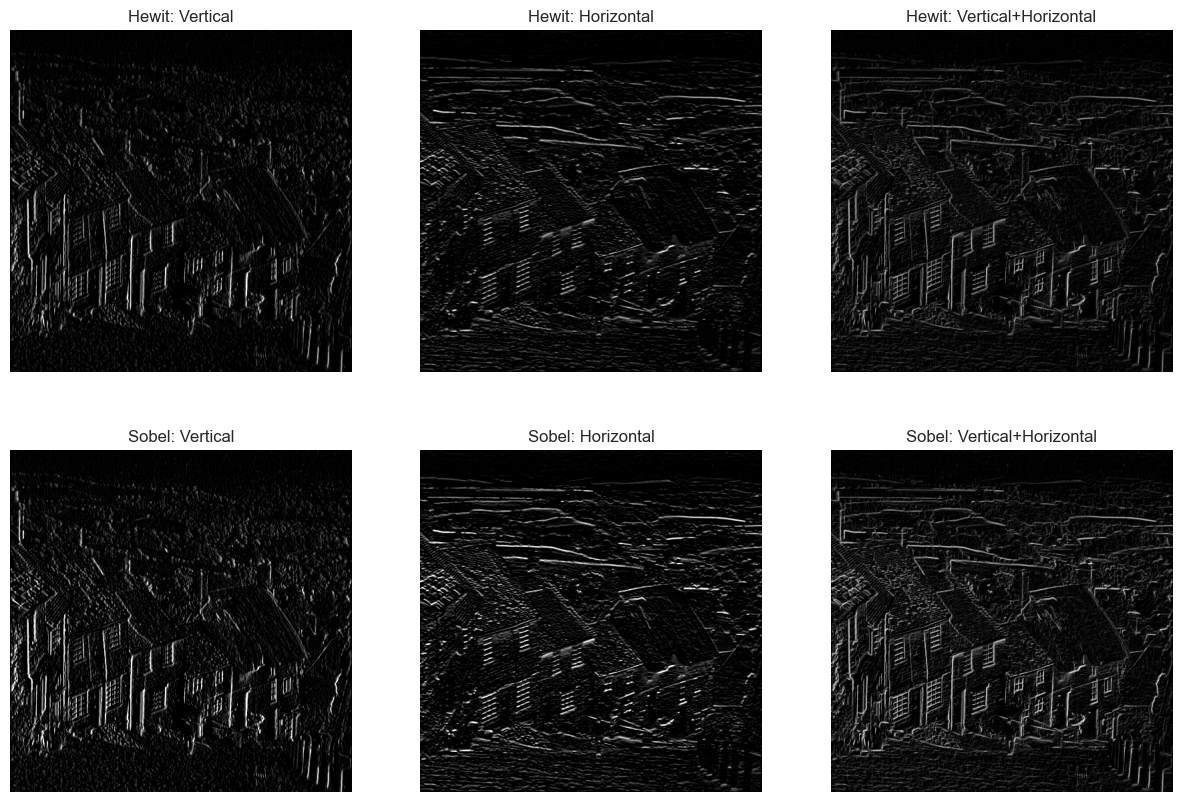

In [69]:
img = images[2]

#bordas geradas com o operador de hewit
hewit_v_img  = cv2.filter2D(src=img, ddepth=-1, kernel=v_hewit)
hewit_h_img  = cv2.filter2D(src=img, ddepth=-1, kernel=h_hewit)
hewit_vh_img = combine_filters(img, v_hewit,h_hewit,mode='root_of_sq')

#imagens a serem plotadas
plot_imgs = [hewit_v_img,hewit_h_img,hewit_vh_img,
             h3_img,h4_img,h34_root_of_sq]

#rótulos de cada imagem
labels = ['Hewit: Vertical','Hewit: Horizontal','Hewit: Vertical+Horizontal',
          'Sobel: Vertical','Sobel: Horizontal','Sobel: Vertical+Horizontal']

axes = plot_images(plot_imgs, 
                   labels,
                   images_per_line=3,
                   img_size=5)

Conforme já citado, o operador de Sobel destaca mais as bordas do que o de Hewitt pois substitui os 1’s na coluna central por 2’s.

#### Laplaciano (h5, h1)

O kernel laplaciano (ou passa alta) pode realçar as bordas em todas as direções (inclusive na diagonal). Mas tem como desvantagem ser altamente sensível a ruídos.

5x5

In [70]:
print(h1)

[[ 0  0 -1  0  0]
 [ 0 -1 -2 -1  0]
 [-1 -2 16 -2 -1]
 [ 0 -1 -2 -1  0]
 [ 0  0 -1  0  0]]


3x3

In [71]:
print(h5)

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


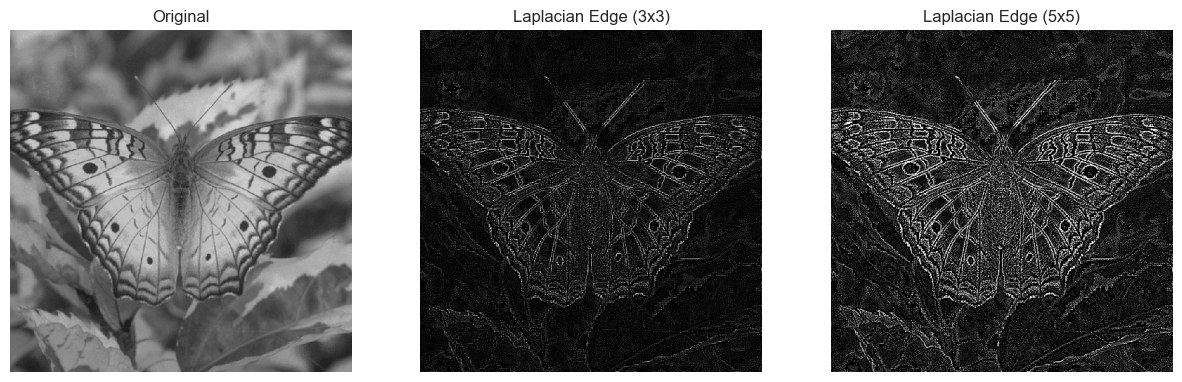

In [72]:
img = images[1]
h5_img = cv2.filter2D(src=img, ddepth=-1, kernel=h[4])
h1_img = cv2.filter2D(src=img, ddepth=-1, kernel=h[0])
plot_images([img,h5_img,h1_img], 
            ['Original',effect_label[4],effect_label[0]],
            images_per_line=3,
            img_size=5);

##### Laplacian of Gaussian

Para amenizar os ruídos, uma estratégia comum é utilizar o laplaciano após um gaussiano (Laplacian of Gaussian)

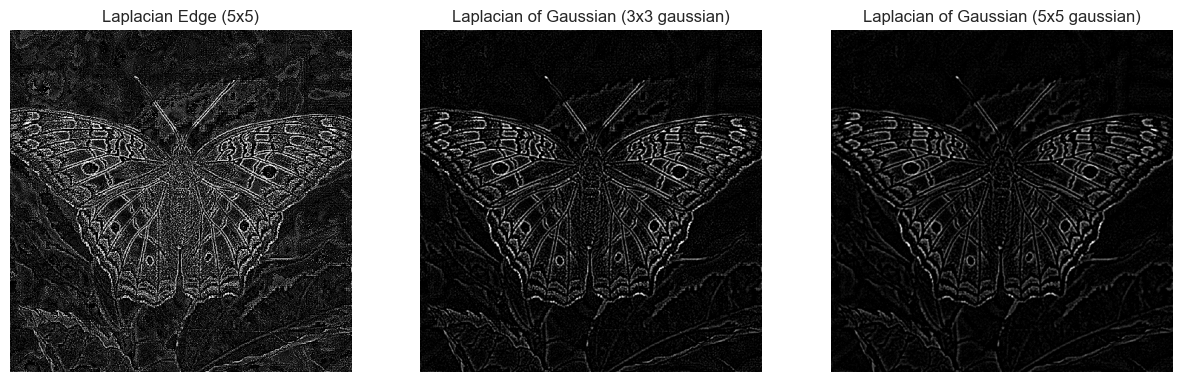

In [73]:
lapl_of_gauss_3_img = cv2.filter2D(src=img, ddepth=-1, kernel=gaussian_kernel(3))
lapl_of_gauss_3_img = cv2.filter2D(src=lapl_of_gauss_3_img, ddepth=-1, kernel=h[0])

lapl_of_gauss_5_img = cv2.filter2D(src=img, ddepth=-1, kernel=gaussian_kernel(5))
lapl_of_gauss_5_img = cv2.filter2D(src=lapl_of_gauss_5_img, ddepth=-1, kernel=h[0])

plot_images([h1_img,lapl_of_gauss_3_img,lapl_of_gauss_5_img], 
            [effect_label[0],'Laplacian of Gaussian (3x3 gaussian)','Laplacian of Gaussian (5x5 gaussian)'],
            images_per_line=3,
            img_size=5);

Observamos que um filtro gaussiano 3x3 já é o suficiente para tirar a maior parte do ruído. Utilizando o filtro gaussiano 5x5 o ruído praticamente some, porém, em algumas regiões da imagem, as bordas ficam pouco realçadas.

### Emboss (h11)

Cria uma impressão de alto relevo substituindo os pixel de bordas da imagem por um highlight ou por uma sombra a depender da borda e as áreas de baixo contraste são substituídas por um background padrão. É possível controlar a direção e o sentido desse relevo de acordo com as posições dos 1's e -1's do filtro.

In [76]:
h11

array([[-1, -1,  0],
       [-1,  0,  1],
       [ 0,  1,  1]])

In [77]:
#matriz do tamanho do filtro com o centro igual a 1 e demais elementos iguais a zero
a = np.zeros_like(h11)
a[int((a.shape[0]-1)/2),int((a.shape[1]-1)/2)] = 1
a

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

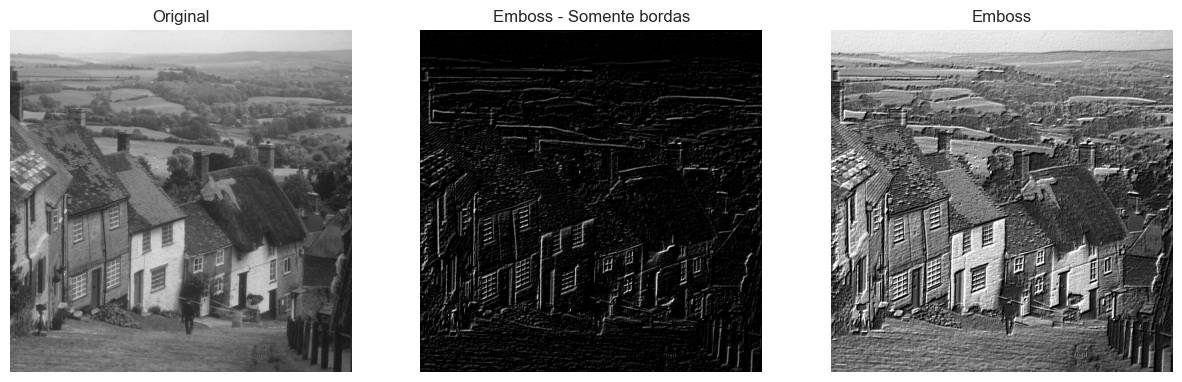

In [78]:
img = images[2]
h11_img = cv2.filter2D(src=img, ddepth=-1, kernel=h11)
h11a_img = cv2.filter2D(src=img, ddepth=-1, kernel=h11+a)
plot_images([img,h11_img,h11a_img], 
            ['Original',effect_label[10]+' - Somente bordas',effect_label[10]],
            images_per_line=3,
            img_size=5);